In [ ]:
# default_exp pnnlDatasets

## Import libraries

This class reads in a dataset and does the necessary preprocessing for a pytorch model.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# EXPORT
#from torchvision import datasets, transforms
import os, sys
from glob import glob
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import pandas as pd
from scipy.interpolate import interp2d, griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re

## PNNL CCSI_2D Dataset Class

In [ ]:
# EXPORT
def plotData(grid_x, grid_y, grid_z, title, pngFile=None):
    plt.figure()
    ax = plt.gca()
    im = ax.pcolormesh(grid_y,grid_x, grid_z, cmap='RdYlBu')
    plt.axes().set_aspect('equal')
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    if pngFile:
        plt.savefig(pngFile, dpi=300)
        plt.close()
        
def interpData(x,y,z,Nx=None,Ny=None,delta_x=None,nextPow2=False,method='linear'):
    '''
    This function takes 3 lists of points (x,y,z) and maps them to a 
    rectangular grid. Either Nx or Ny must be set or delta_x must be set. 
    e.g. 
    
    x = y = z = np.random.rand(30)
    grid_x, grid_y, grid_z = interpData(x,y,z,Nx=128,Ny=128)
    
    or 
    
    grid_x, grid_y, grid_z = interpData(x,y,z,delta_x=1e-3,nextPow2=True)
    '''
    
    eps = 1e-4 # needed to make sure that the interpolation does not have nans. 
    def _NextPowerOfTwo(number):
        # Returns next power of two following 'number'
        return np.ceil(np.log2(number))
    
    if Nx == None and Ny == None:
        assert delta_x != None
        delta_y = delta_x
        Nx = int((x.max() - x.min())/delta_x)
        Ny = int((y.max() - y.min())/delta_y)

    if nextPow2:
        Nx = 2**_NextPowerOfTwo(Nx)
        Ny = 2**_NextPowerOfTwo(Ny)
        
    grid_x, grid_y = np.mgrid[x.min()+eps:x.max()-eps:Nx*1j,y.min()+eps:y.max()-eps:Ny*1j]
    grid_z = griddata(np.array([x,y]).T, z, (grid_x, grid_y), method=method)
    return grid_x, grid_y, grid_z

def plotFrame(fn):
    D = pd.read_csv(fn)
    x = D['X (m)']
    y = D['Y (m)']
    for d in D.columns[:4]:
        z = D[d]
        grid_x, grid_y, grid_z = interpData(x.values,y.values,z.values,delta_x=1e-4)
        idx = getInt(fn)
        d = d.replace(' ','_')
        d = re.sub(r'[^A-Za-z0-9 ]+', '_', d)[:-1]
        title = '{}, Time Step: {}'.format(d,idx)
        pngFile = '{}_{}.png'.format(d,idx)
        plotData(grid_y, grid_x, grid_z, title, pngFile)

        
class CCSI_2D(Dataset):
    def __init__(self, 
                 dataDirec='/data/ccsi/PNNLTimeStepData/001a/',
                 numToKeep=np.infty,transform=None,preprocess=True,
                 Nx=None,Ny=None,delta_x=None,nextPow2=True,interpMethod='linear'): 
        
        self.data = []
        self.files = []
        self.delta_x = delta_x
        self.nextPow2 = nextPow2
        self.Nx = Nx
        self.Ny = Ny
        self.grid_x = []
        self.grid_y = []
        self.preprocess = preprocess
        self.interpMethod = interpMethod
        
        if type(dataDirec) == list:
            self.files = dataDirec
        elif 'pkl' in dataDirec:
            with open(dataDirec,'rb') as fid:
                D = pickle.load(fid)
                self.data = np.array(D['data'])
                self.grid_x = D['grid_x']
                self.grid_y = D['grid_y']
                if numToKeep < len(self.data):
                     self.data = self.data[:numToKeep]
        else:
            files = glob(os.path.join(dataDirec,'*.csv'))       
            L = np.argsort(list(map(getInt,files)))
            self.files = [files[i] for i in L]
            
        self.dataDirec = dataDirec
        self.numToKeep = numToKeep
        self.transform = transform
        self.preprocess = preprocess
        self.column = []

        
        if self.files is not []:
            if numToKeep < len(self.files):
                self.files = self.files[:numToKeep]

            for f in self.files:
                self.data.append(self.loadfile(f)) 
                
        if preprocess:
            for i, d in enumerate(self.data):
                self.data[i] = self.preprocessFcn(d)

    def loadfile(self,fn):
        D = pd.read_csv(fn)
        x = D['X (m)'].values.astype('float32')
        y = D['Y (m)'].values.astype('float32')
        X = []
        for d in D.columns[:4]:
            z = D[d].values.astype('float32')
            grid_x, grid_y, grid_z = interpData(x,y,z,
                                                self.Nx,self.Ny,
                                                self.delta_x,self.nextPow2,
                                                self.interpMethod)
            X.append(grid_z)
            
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.column = D.columns[:4]
        return np.array(X).astype('float32')

    
    def preprocessFcn(self, X,mx=[5.46,4.1,1.,2012.],
                      mn=[-4.8, -8.8,0.,-1725.]):
        # mx and mn are the maximums and minimums
        # of the original data's 4 channels.
        assert len(X) == 4
        Xnew = np.empty_like(X)
        cnt = 0
        for x,M,m in zip(X,mx,mn):
            Xnew[cnt] = 2*((x-m)/(M-m) - .5) 
            cnt += 1
        return Xnew

    def inversePreprocessFcn(self, X,mx=[5.46,4.1,1.,2012.],
                             mn=[-4.8, -8.8,0.,-1725.]):
        assert len(X) == 4
        Xnew = np.empty_like(X)
        cnt = 0
        for x,M,m in zip(X,mx,mn):
            Xnew[cnt] = (M - m)*((x/2) + .5) + m 
            cnt += 1
        return Xnew
    
    def __len__(self):
        return len(self.data)


    def plotData(self,idx,pngFile=None):
        D = self.data[idx]
        for i in range(4):
            grid_z = D[i]
            plt.figure()
            ax = plt.gca()
            im = ax.pcolormesh(self.grid_x,self.grid_y, grid_z, cmap='RdYlBu')
            plt.axes().set_aspect('equal')
            plt.title('Sample {}, {}'.format(idx,self.column[i]))
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            if pngFile:
                plt.savefig(pngFile, dpi=300)
                plt.close()

    def __getitem__(self, idx):
        X  = self.data[idx].astype('float32')
        if self.transform is not None:
            X = self.transform(X)
        return X,X # this allows LR_finder to work


# these functions are in the class too
def preprocessFcn(X,mx=[5.46,4.1,1.,2012.],
                 mn=[-4.8, -8.8,0.,-1725.]):
    # maps the X to [-1,1]
    assert len(X) == 4
    Xnew = np.empty_like(X)
    cnt = 0
    for x,M,m in zip(X,mx,mn):
        Xnew[cnt] = 2*((x-m)/(M-m) - .5) 
        cnt += 1
    return Xnew

def inversePreprocessFcn(X,mx=[5.46,4.1,1.,2012.],
                 mn=[-4.8, -8.8,0.,-1725.]):
    Xnew = np.empty_like(X)
    cnt = 0
    for x,M,m in zip(X,mx,mn):
        Xnew[cnt] = (M - m)*((x/2) + .5) + m 
        cnt += 1
    return Xnew



## Playground test the CCSI_2D class

In [ ]:
# each sim is broken into two directories 'a' and 'b'
dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
sims = ['001','025','050']
simIdx = 0
files = []
for i in ['a','b']:
    pth = os.path.join(dataDirec,sims[simIdx] + i)
    files.append(glob(os.path.join(pth,'*.csv')))
files = [i for sublist in files for i in sublist]
len(files)

500

In [ ]:
# EXPORT
def getInt(f):
    return int(f.split('_')[-1].replace('.csv',''))

In [ ]:
L = np.argsort(list(map(getInt,files)))
L

array([  0, 112, 173, 184, 195, 206, 217, 228, 239,   1,  12,  24,  35,
        46,  57,  23,  79,  90, 101, 113, 124, 135,  71, 156, 163, 169,
       170, 171, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249,   2,   3,   4,   5,   6,
         7,   8,   9,  10,  11,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,  77,  78,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  91,  9

In [ ]:
orderedFiles = [files[i] for i in L]
orderedFiles

['/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_10.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_20.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_30.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_40.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_50.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_60.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_70.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_80.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_90.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_100.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_110.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_120.csv',
 '/data/ccsi/PNNLTimeStepData/rars/001a/XYZ_Internal_Table_table_130.csv',
 '/data/ccsi/PNNLTimeStepData/rars

In [ ]:
D = pd.read_csv(orderedFiles[0])
x = D['X (m)']
y = D['Y (m)']
vj = D['Velocity[j] (m/s)']

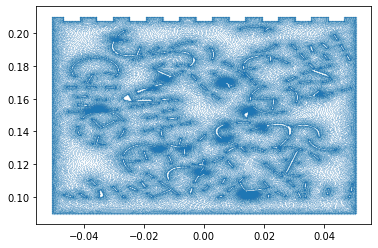

In [ ]:
plt.scatter(x,y,s=.01)
plt.show()

In [ ]:
grid_x, grid_y, grid_z = interpData(x.values,y.values,vj.values,Nx=512,Ny=512)
grid_x.shape, grid_y.shape, grid_z.shape

((512, 512), (512, 512), (512, 512))

In [ ]:
len(x), grid_x.size # the original dataset vs. interpolated

(150073, 262144)

In [ ]:
grid_x, grid_y, grid_z = interpData(x.values,y.values,vj.values,delta_x=1e-3,nextPow2=True)
grid_x.shape, grid_y.shape, grid_z.shape

((128, 128), (128, 128), (128, 128))

In [ ]:
len(x), grid_x.size # the original dataset vs. interpolated

(150073, 16384)

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


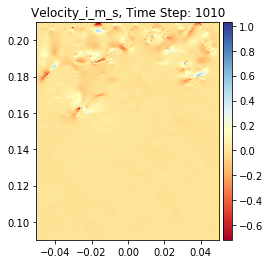

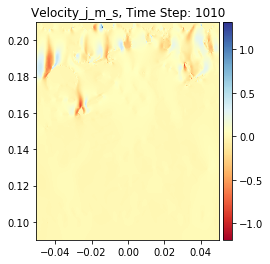

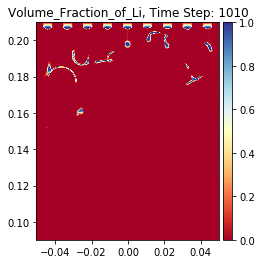

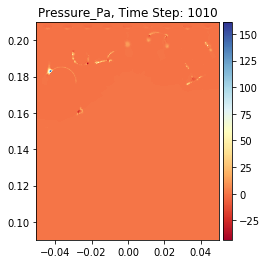

In [ ]:
plotFrame(orderedFiles[100])

In [ ]:
D = CCSI_2D(orderedFiles,Nx=128,Ny=128,numToKeep=1,interpMethod='cubic')

In [ ]:
np.any(np.isnan(D.data))

False

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:166: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


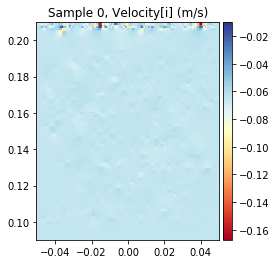

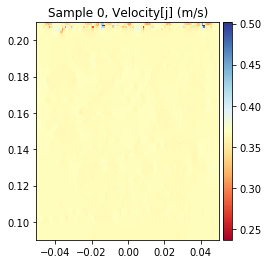

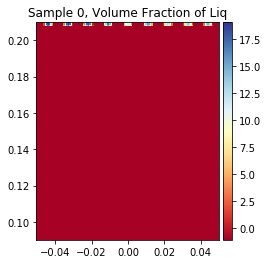

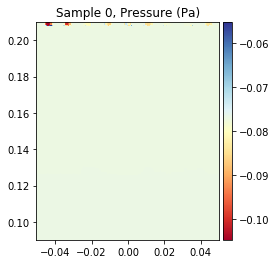

In [ ]:
D.plotData(0)

In [ ]:
D = CCSI_2D(orderedFiles,delta_x=1e-4,nextPow2=True,numToKeep=1)

False


/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:166: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


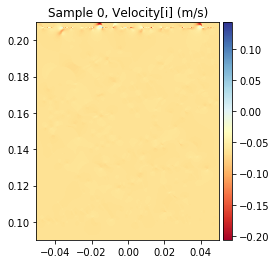

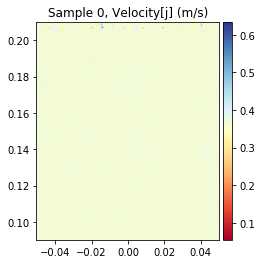

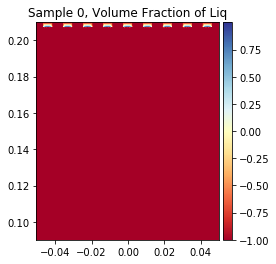

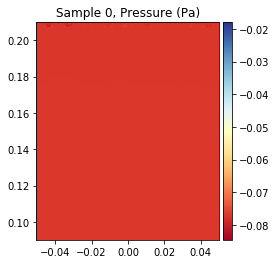

In [ ]:
print(np.any(np.isnan(D.data)))
D.plotData(0)

### Create the 128x128 dataset

In [ ]:
# from surrogates4sims.utils import pkl_save
# outdirec = '/data/ccsi/PNNLTimeStepData/data_128x128_linear'
# if not os.path.exists(outdirec):
#     os.makedirs(outdirec)
    
# dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
# sims = ['001','025','050']
# for s in tqdm(sims):
#     files = []
#     for i in ['a','b']:
#         pth = os.path.join(dataDirec,sims[simIdx] + i)
#         files.append(glob(os.path.join(pth,'*.csv')))
#     files = [i for sublist in files for i in sublist]
#     L = np.argsort(list(map(getInt,files)))
#     orderedFiles = [files[i] for i in L]
#     D = CCSI_2D(orderedFiles,Nx=128,Ny=128)
#     data = {'grid_x':D.grid_x, 'grid_y': D.grid_y, 'data':D.data}
#     s = os.path.join(outdirec,s + '.pkl')
#     pkl_save(data,s)

In [ ]:
## cubic dataset 
# D = CCSI_2D(orderedFiles,Nx=128,Ny=128,interpMethod='cubic') # takes 1.5 hours
# data = {'grid_x':D.grid_x, 'grid_y': D.grid_y, 'data':D.data}
# s = os.path.join('/data/ccsi/PNNLTimeStepData/data_128x128_cubic',sims[simIdx] + '.pkl')
# with open(s,'wb') as fid:
#     pickle.dump(data,fid)

### Create the 512x512 dataset

In [ ]:
from surrogates4sims.utils import pkl_save
n = 512
outdirec = '/data/ccsi/PNNLTimeStepData/data_{}x{}_linear'.format(n,n)
if not os.path.exists(outdirec):
    os.makedirs(outdirec)
    
dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
sims = ['001','025','050']
for s in tqdm(sims):
    files = []
    for i in ['a','b']:
        pth = os.path.join(dataDirec,sims[simIdx] + i)
        files.append(glob(os.path.join(pth,'*.csv')))
    files = [i for sublist in files for i in sublist]
    L = np.argsort(list(map(getInt,files)))
    orderedFiles = [files[i] for i in L]
    D = CCSI_2D(orderedFiles,Nx=n,Ny=n)
    data = {'grid_x':D.grid_x, 'grid_y': D.grid_y, 'data':D.data}
    s = os.path.join(outdirec,s + '.pkl')
    pkl_save(data,s)

100%|██████████| 3/3 [3:25:14<00:00, 4104.82s/it]  


### Read in the saved dataset above

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128_cubic/025.pkl',preprocess=False)
len(D)

500

In [ ]:
a = D.preprocessFcn(D[0][0])
a.shape

(4, 128, 128)

In [ ]:
b = D.inversePreprocessFcn(a)
b.shape

(4, 128, 128)

In [ ]:
np.max(np.abs(b-D[0][0]))

6.1035156e-05

### Create the preprocessing function

In [ ]:
dataDirec = '/data/ccsi/PNNLTimeStepData/rars/'
sims = ['001','025','050']

files = []
for s in sims:
    for i in ['a','b']:
        pth = os.path.join(dataDirec,s + i)
        files.append(glob(os.path.join(pth,'*.csv')))
files = [i for sublist in files for i in sublist]
len(files)

In [ ]:
x = D.max().values
x.shape

In [ ]:
mx = -100*np.zeros((1,n))
mx.shape

In [ ]:
n = 4
mx = -100*np.zeros((1,n))
mn = 100*np.zeros((1,n))
for f in files:
    D = pd.read_csv(f)
    
    M = D.max().values[:4].reshape(1,n)
    out = np.concatenate([mx,M])
    mx = np.max(out,axis=0).reshape(1,n)
    
    m = D.min().values[:4].reshape(1,n)
    out = np.concatenate([mn,m])
    mn = np.min(out,axis=0).reshape(1,n)

print(mx,mn)

In [ ]:
def preprocess(X,mx=[5.46,4.1,1.,2012.],
                 mn=[-4.8, -8.8,0.,-1725.]):
    Xnew = np.empty_like(X)
    cnt = 0
    for x,M,m in zip(X,mx,mn):
        Xnew[cnt] = 2*((x-m)/(M-m) - .5) 
        cnt += 1
    return Xnew


## Histograms

-1.4806442 1.9464293


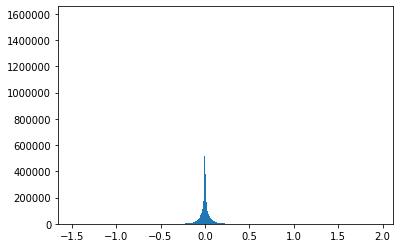

-3.4215562 2.0513844


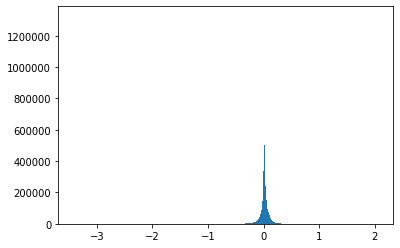

0.0 1.0


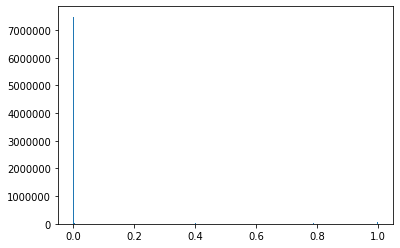

-205.61508 466.0995


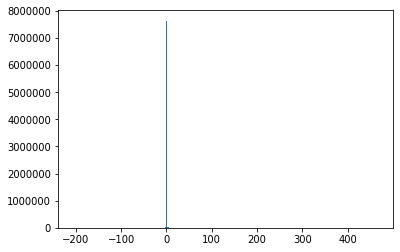

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128_linear/025.pkl',preprocess=False)
X = D.data
for i in range(X.shape[1]):
    E = X[:,i]
    E = E.flatten()
    mn, mx = E.min(),E.max()
    print(mn,mx)
    bins = np.linspace(mn,mx,1000)
    plt.hist(E,bins)
    plt.show()

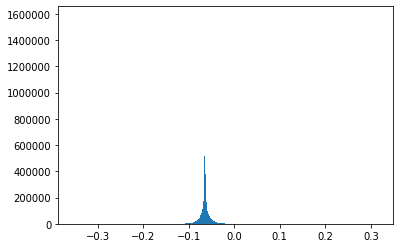

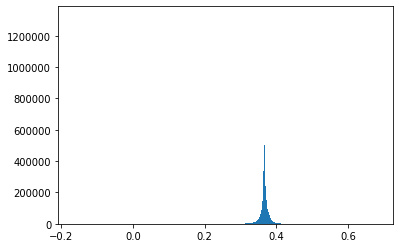

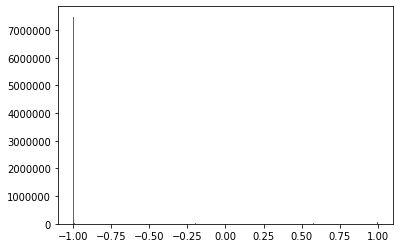

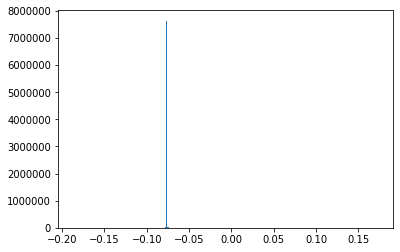

In [ ]:
D = CCSI_2D('/data/ccsi/PNNLTimeStepData/data_128x128_linear/025.pkl',preprocess=True)
X = D.data
for i in range(X.shape[1]):
    E = X[:,i]
    E = E.flatten()
    bins = np.linspace(E.min(),E.max(),1000)
    plt.hist(E,bins)
    plt.show()

In [ ]:
E.max()

466.0995

In [ ]:
E.min()

-205.61508

In [ ]:
E = X[:,2]
E = E.flatten()

In [ ]:
E

array([-1.        , -1.        , -1.        , ..., -0.99999684,
       -0.9999989 , -0.9999968 ], dtype=float32)

In [ ]:
E.max(), E.min(), np.mean(E), np.median(E)

(1.0, -1.0, -0.93551517, -1.0)

In [ ]:
mu = E.mean()
sig = E.std()
sig

0.31372204

In [ ]:
En = (E - mu)/sig

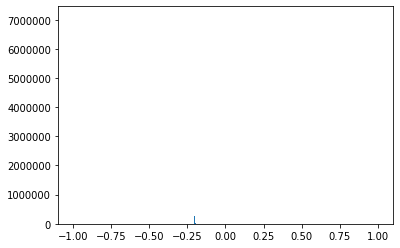

In [ ]:
bins = np.linspace(E.min(),E.max(),1000)
plt.hist(En,bins)
plt.show()

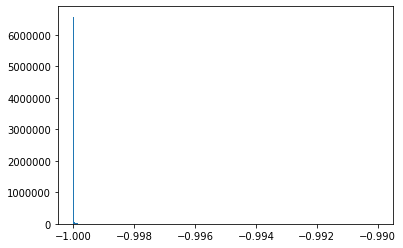

In [ ]:
bins = np.linspace(E.min(),-.99,1000)
plt.hist(E,bins)
plt.show()

In [ ]:
En.min(),mu + 1*sig

(-0.20554768, -0.621793121099472)

In [ ]:
En

array([-0.20554768, -0.20554768, -0.20554768, ..., -0.2055376 ,
       -0.20554425, -0.20553741], dtype=float32)

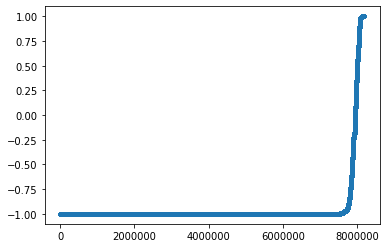

In [ ]:
plt.plot(sorted(E),'.')

In [ ]:
np.sum(E==-1.)/len(E)

0.5883387451171875

In [ ]:
np.sum(E==1.)/len(E)

0.0012620849609375

In [ ]:
np.sum(E > -1.)/len(E)

0.4116612548828125

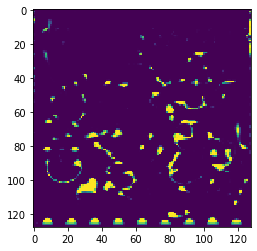

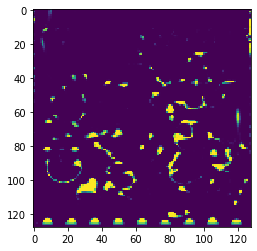

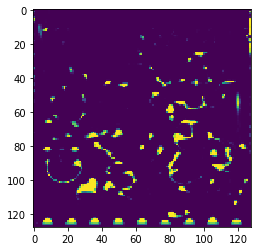

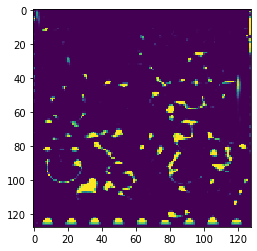

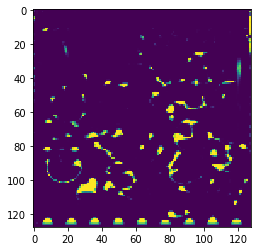

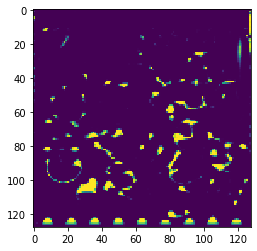

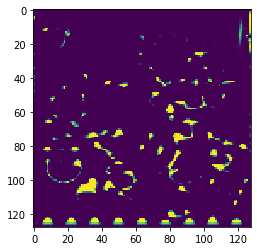

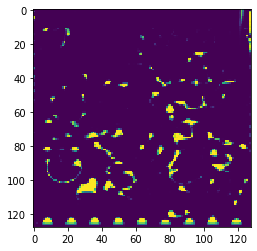

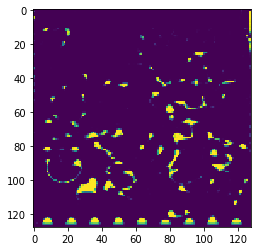

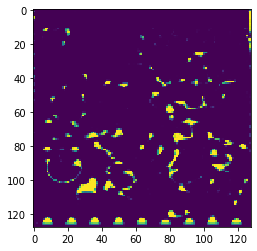

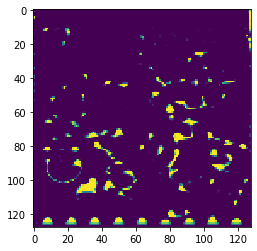

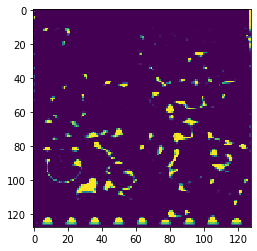

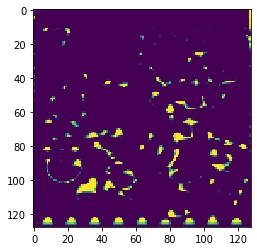

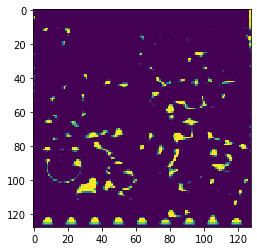

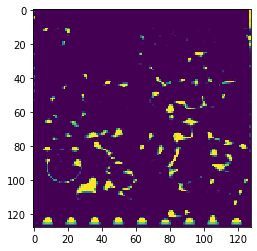

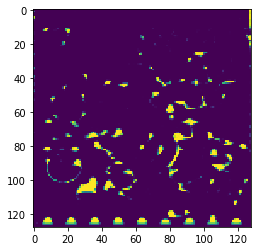

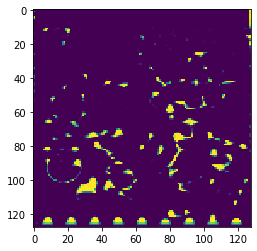

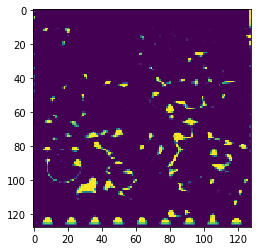

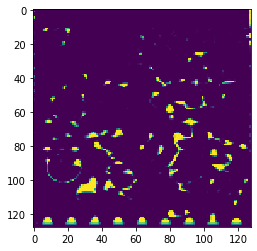

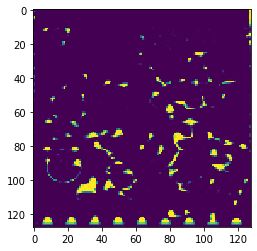

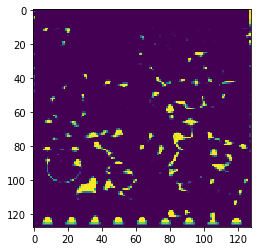

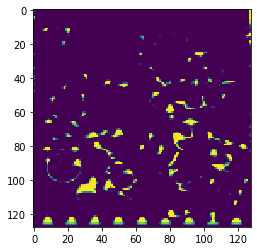

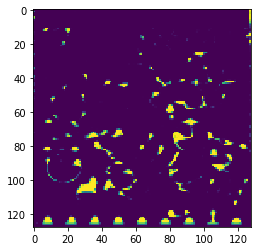

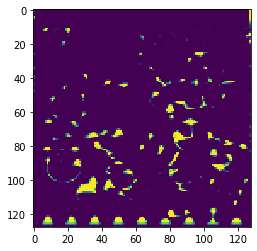

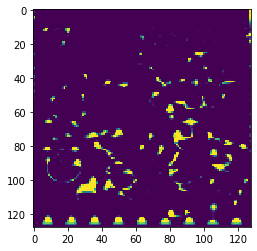

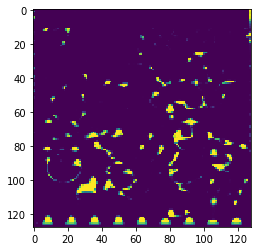

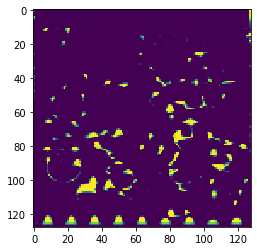

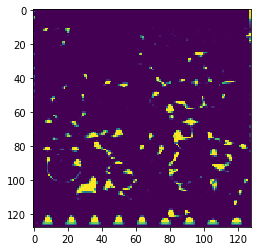

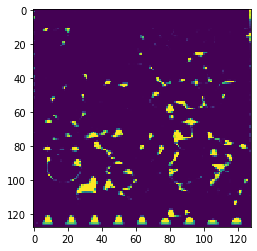

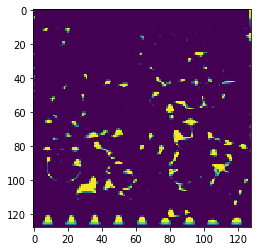

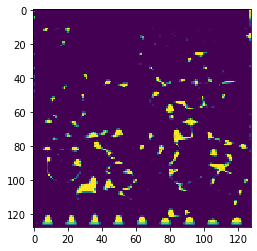

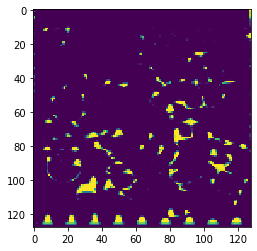

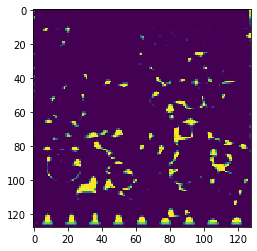

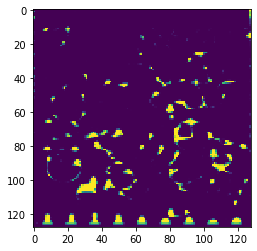

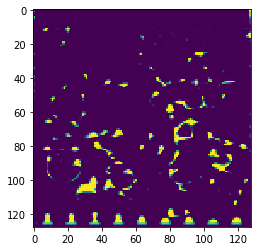

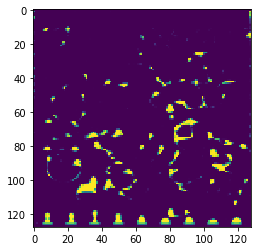

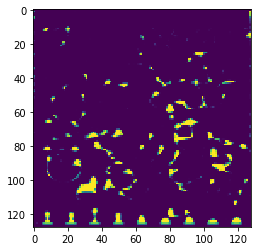

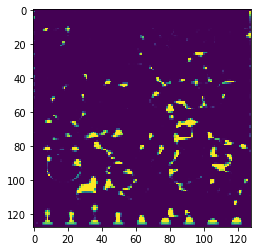

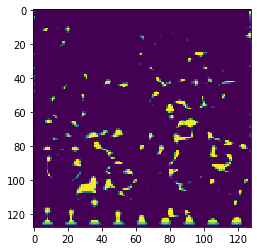

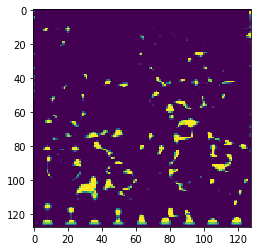

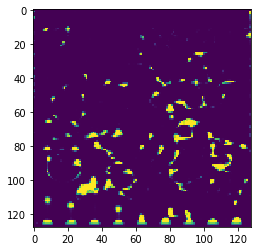

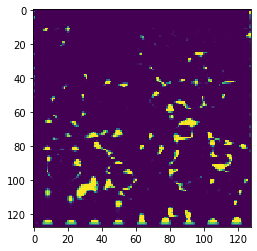

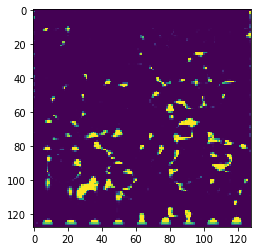

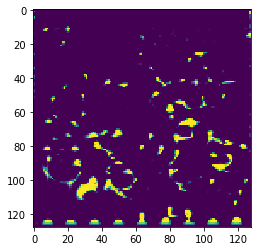

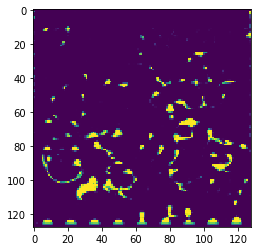

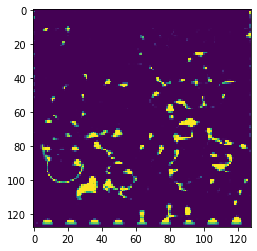

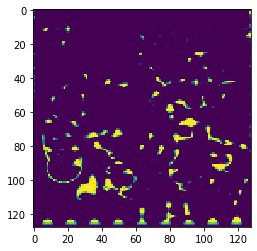

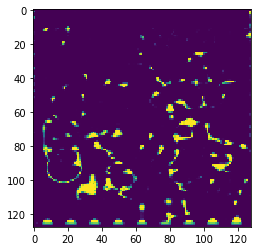

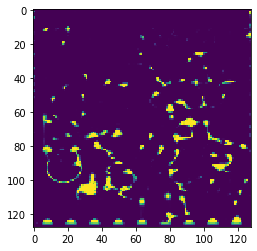

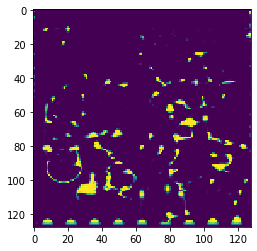

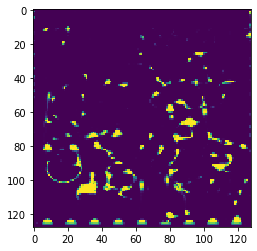

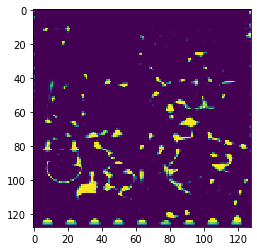

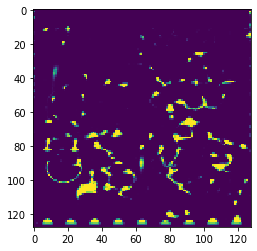

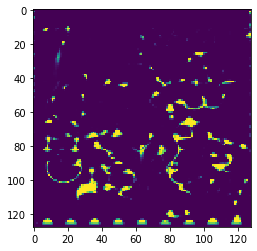

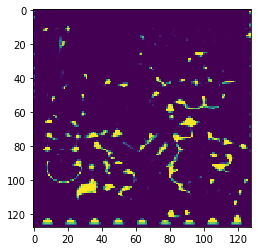

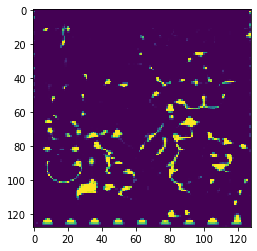

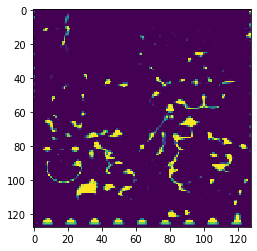

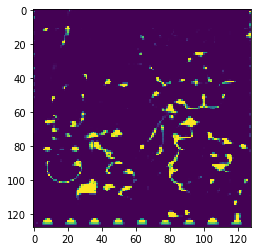

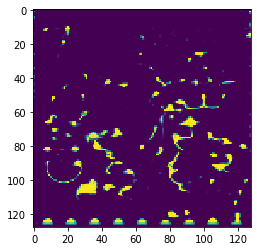

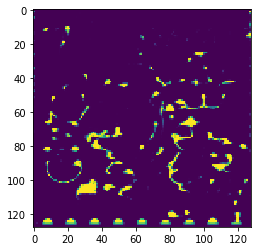

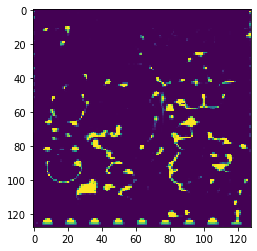

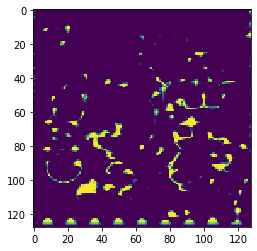

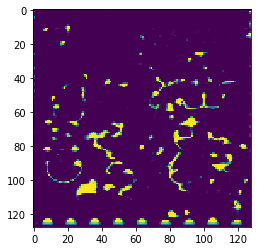

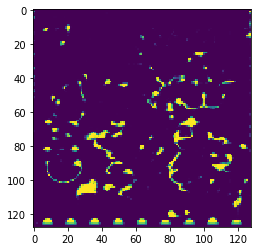

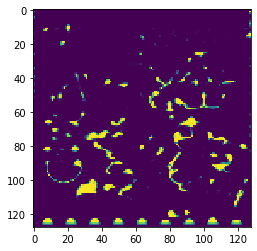

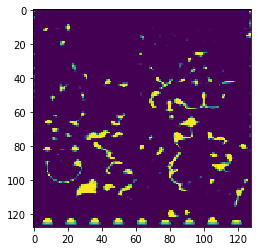

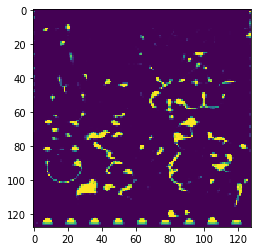

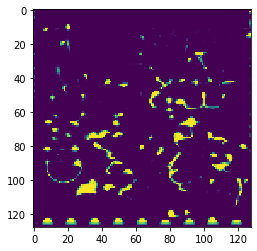

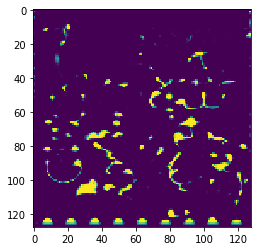

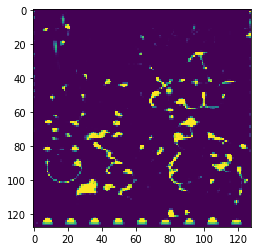

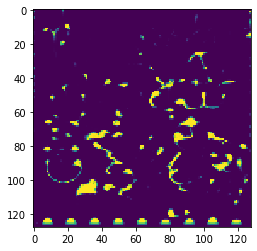

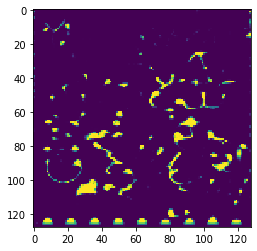

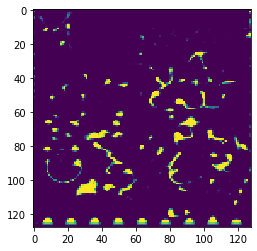

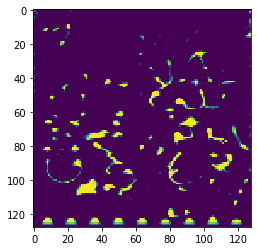

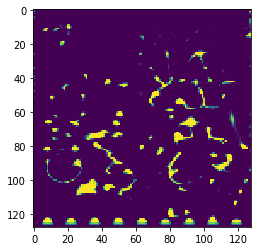

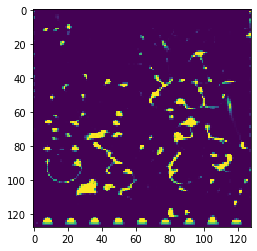

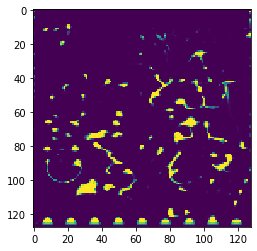

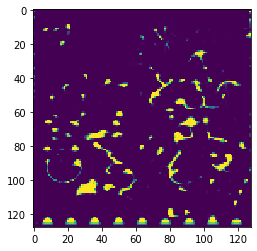

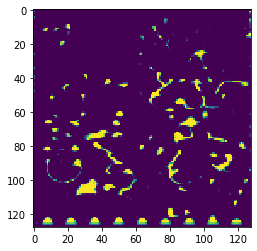

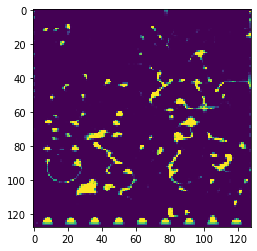

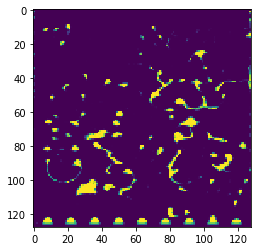

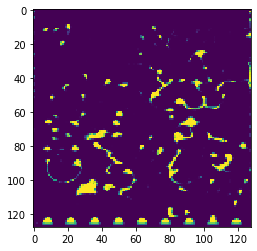

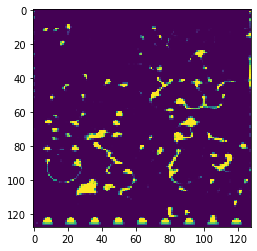

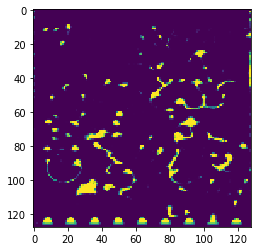

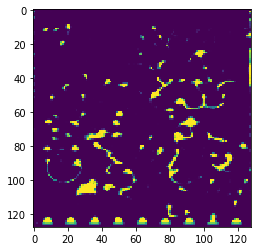

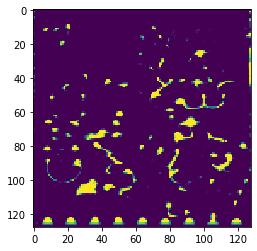

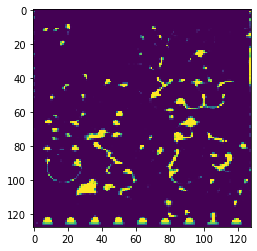

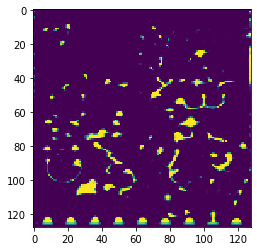

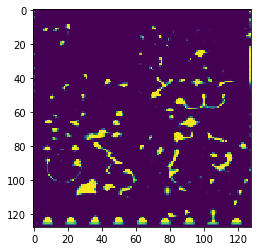

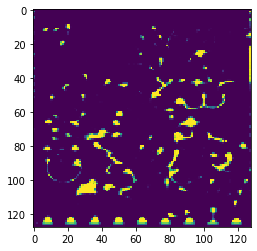

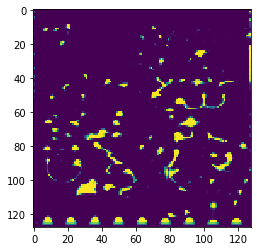

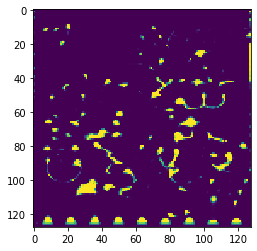

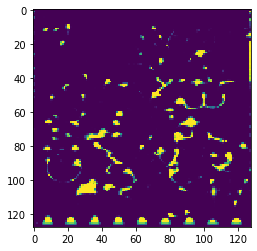

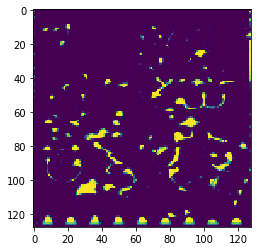

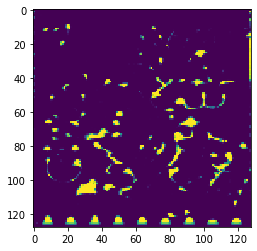

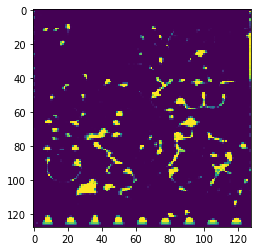

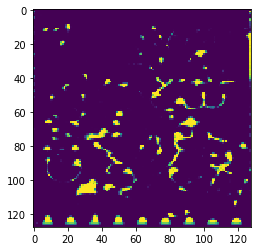

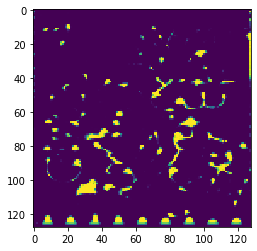

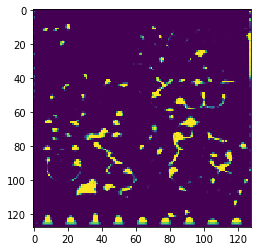

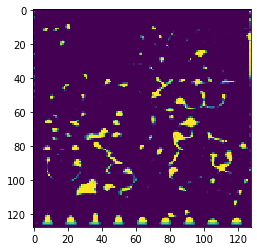

In [ ]:
A = X[:,2]
for a in A[400:]:
    plt.imshow(a.T)
    plt.show()

16384